## In this code, we will download tornado data from the NOAA website, plot the training data after applying initial filters and perform a kernel density estimation to obtain a csv file with peak latitudes and longitudes

 We need to seperately download files from 1951-2007, then 2008-2019 because of some changes in how the NOAA data is stored after 2007. Our filters are: State, Event - Tornado, Year, and Beginning Latitude and Longitude. We are only tracking where the tornadoes begin and not their path length to avoid data leakage. Next, we select only EF3, EF4, EF5 tornadoes (high intensity tornadoes) and  begin_lat < -75, begin_long < 32 (to remove hurricane related tornadoes). Finallly, we binned the data in a bin size of 3 years.

In [18]:
import pandas as pd
import requests
from io import BytesIO
from shapely.geometry import Point
import geopandas as gpd

base_url = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/"
creation_date = "20250520"  
all_years_data = []


for year in range(1952, 2008):
    print(f"\nProcessing year: {year}")

    details_file = f"StormEvents_details-ftp_v1.0_d{year}_c{creation_date}.csv.gz"


    def download_csv_gz(file_name):
        url = base_url + file_name
        try:
            r = requests.get(url)
            r.raise_for_status()
            return pd.read_csv(BytesIO(r.content), compression='gzip', low_memory=False)
        except Exception as e:
            print(f"Failed to load {file_name}: {e}")
            return None

    df_details = download_csv_gz(details_file)

    if df_details is None:
        continue

    df_details.columns = df_details.columns.str.lower()
 
    if 'event_id' not in df_details.columns:
        continue

    
    df_tornadoes = df_details[
    (df_details['event_type'] == 'Tornado') &
    (df_details['tor_f_scale'].isin(['F0', 'F1', 'F2', 'F3', 'F4', 'F5']))].copy()

        # Remove likely hurricane tornadoes
    df_tornadoes = df_tornadoes[
    ~((df_tornadoes['begin_lon'] < -75) & (df_tornadoes['begin_lat'] < 32))]

    df_tornadoes['year'] = year  


    if df_tornadoes.empty:
        continue

    
    df_tornadoes['year'] = year
    all_years_data.append(df_tornadoes[['state', 'begin_lat', 'begin_lon', 'tor_f_scale', 'year']])


combined_df = pd.concat(all_years_data, ignore_index=True)

def year_to_bin(y):
    base = y - (y % 4)
    return f"{base}-{base + 3}"

combined_df['year_bin'] = combined_df['year'].apply(year_to_bin)


binned_summary = combined_df.groupby(['year_bin', 'state', 'begin_lat', 'begin_lon', 'tor_f_scale']) \
                            .size().reset_index(name='count')


binned_summary.to_csv("1952_2007.csv", index=False)




Processing year: 1952

Processing year: 1953

Processing year: 1954

Processing year: 1955

Processing year: 1956

Processing year: 1957

Processing year: 1958

Processing year: 1959

Processing year: 1960

Processing year: 1961

Processing year: 1962

Processing year: 1963

Processing year: 1964

Processing year: 1965

Processing year: 1966

Processing year: 1967

Processing year: 1968

Processing year: 1969

Processing year: 1970

Processing year: 1971

Processing year: 1972

Processing year: 1973

Processing year: 1974

Processing year: 1975

Processing year: 1976

Processing year: 1977

Processing year: 1978

Processing year: 1979

Processing year: 1980

Processing year: 1981

Processing year: 1982

Processing year: 1983

Processing year: 1984

Processing year: 1985

Processing year: 1986

Processing year: 1987

Processing year: 1988

Processing year: 1989

Processing year: 1990

Processing year: 1991

Processing year: 1992

Processing year: 1993

Processing year: 1994

Processing

In [20]:
import pandas as pd
import requests
from io import BytesIO
from shapely.geometry import Point
import geopandas as gpd

base_url = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/"
creation_date = "20250520"  
all_years_data = []


for year in range(2008, 2020):
    print(f"\nProcessing year: {year}")

    details_file = f"StormEvents_details-ftp_v1.0_d{year}_c{creation_date}.csv.gz"


    def download_csv_gz(file_name):
        url = base_url + file_name
        try:
            r = requests.get(url)
            r.raise_for_status()
            return pd.read_csv(BytesIO(r.content), compression='gzip', low_memory=False)
        except Exception as e:
            print(f"Failed to load {file_name}: {e}")
            return None

    df_details = download_csv_gz(details_file)

    if df_details is None:
        continue

    df_details.columns = df_details.columns.str.lower()

    if 'event_id' not in df_details.columns:
        continue

    
    df_tornadoes = df_details[
    (df_details['event_type'] == 'Tornado') &
    (df_details['tor_f_scale'].isin(['EF0', 'EF1', 'EF2', 'EF3', 'EF4', 'EF5']))].copy()
    # Remove likely hurricane tornadoes
    df_tornadoes = df_tornadoes[
    ~((df_tornadoes['begin_lon'] < -75) & (df_tornadoes['begin_lat'] < 32))]
    df_tornadoes['year'] = year  


    if df_tornadoes.empty:
        continue

    
    df_tornadoes['year'] = year
    all_years_data.append(df_tornadoes[['state', 'begin_lat', 'begin_lon', 'tor_f_scale', 'year']])


combined_df = pd.concat(all_years_data, ignore_index=True)

def year_to_bin(y):
    base = y - (y % 4)
    return f"{base}-{base + 3}"

combined_df['year_bin'] = combined_df['year'].apply(year_to_bin)


binned_summary = combined_df.groupby(['year_bin', 'state', 'begin_lat', 'begin_lon', 'tor_f_scale']) \
                            .size().reset_index(name='count')


binned_summary.to_csv("2008_2019.csv", index=False)




Processing year: 2008

Processing year: 2009

Processing year: 2010

Processing year: 2011

Processing year: 2012

Processing year: 2013

Processing year: 2014

Processing year: 2015

Processing year: 2016

Processing year: 2017

Processing year: 2018

Processing year: 2019


In [21]:
import pandas as pd

df1 = pd.read_csv("1952_2007.csv") 
df2 = pd.read_csv("2008_2019.csv")   

def normalize_scale(scale):
    if isinstance(scale, str) and scale.strip().upper().startswith(('EF', 'F')):
        return f"F{scale[-1]}"  
    return scale

df1['tor_f_scale'] = df1['tor_f_scale'].apply(normalize_scale)
df2['tor_f_scale'] = df2['tor_f_scale'].apply(normalize_scale)

df_combined = pd.concat([df1, df2], ignore_index=True)

df_final = df_combined.groupby(
    ['year_bin', 'state', 'begin_lat', 'begin_lon', 'tor_f_scale']
).agg({'count': 'sum'}).reset_index()


df_final.to_csv("merged_1952_2019.csv", index=False)


### Now we have a clean data file ready, lets plot and see what it looks like

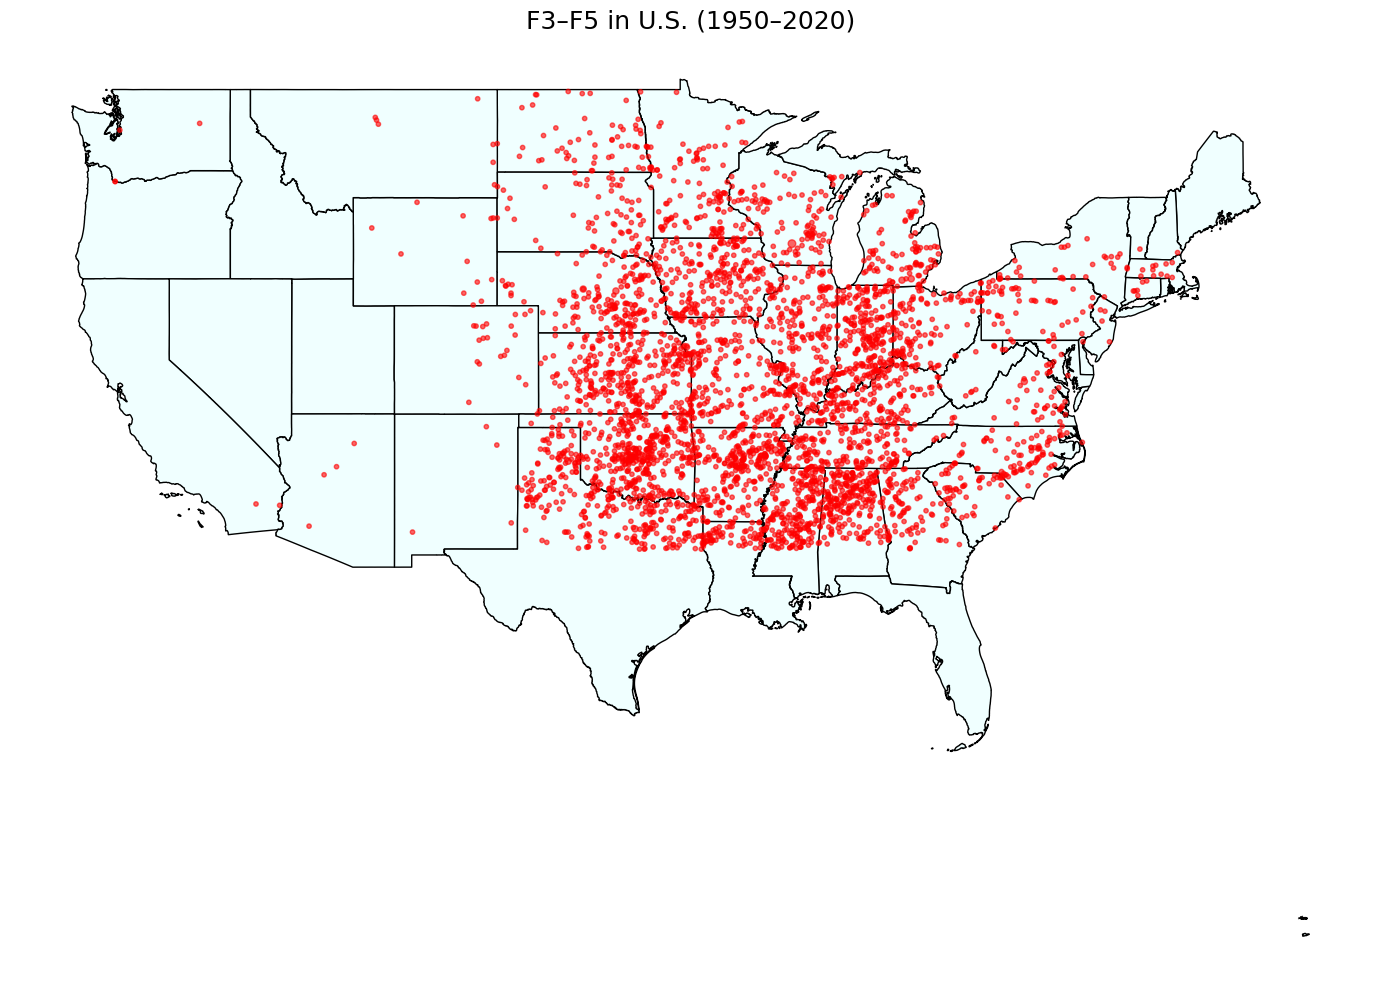

In [22]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point


df = pd.read_csv("merged_1952_2019.csv")


high_df = df[df['tor_f_scale'].isin(['F3', 'F4', 'F5'])]


geometry = [Point(xy) for xy in zip(high_df['begin_lon'], high_df['begin_lat'])]
gdf = gpd.GeoDataFrame(high_df, geometry=geometry, crs="EPSG:4326")


us_states = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_5m.zip")

excluded_states = [
    'ALASKA', 'HAWAII', 'PUERTO RICO', 'GUAM', 'AMERICAN SAMOA',
    'COMMONWEALTH OF THE NORTHERN MARIANA ISLANDS', 'UNITED STATES MINOR OUTLYING ISLANDS'
]

us_states['NAME'] = us_states['NAME'].str.upper()
contiguous_states = us_states[~us_states['NAME'].isin(excluded_states)]


fig, ax = plt.subplots(figsize=(15, 10))


contiguous_states.plot(ax=ax, color='azure', edgecolor='black')


gdf.plot(ax=ax, color='red', markersize=gdf['count'] * 10, alpha=0.6)


ax.set_title("F3–F5 in U.S. (1950–2020)", fontsize=18)
ax.set_axis_off()
plt.tight_layout()
plt.show()


## Let's plot it by each time frame bin and see what our training data looks like

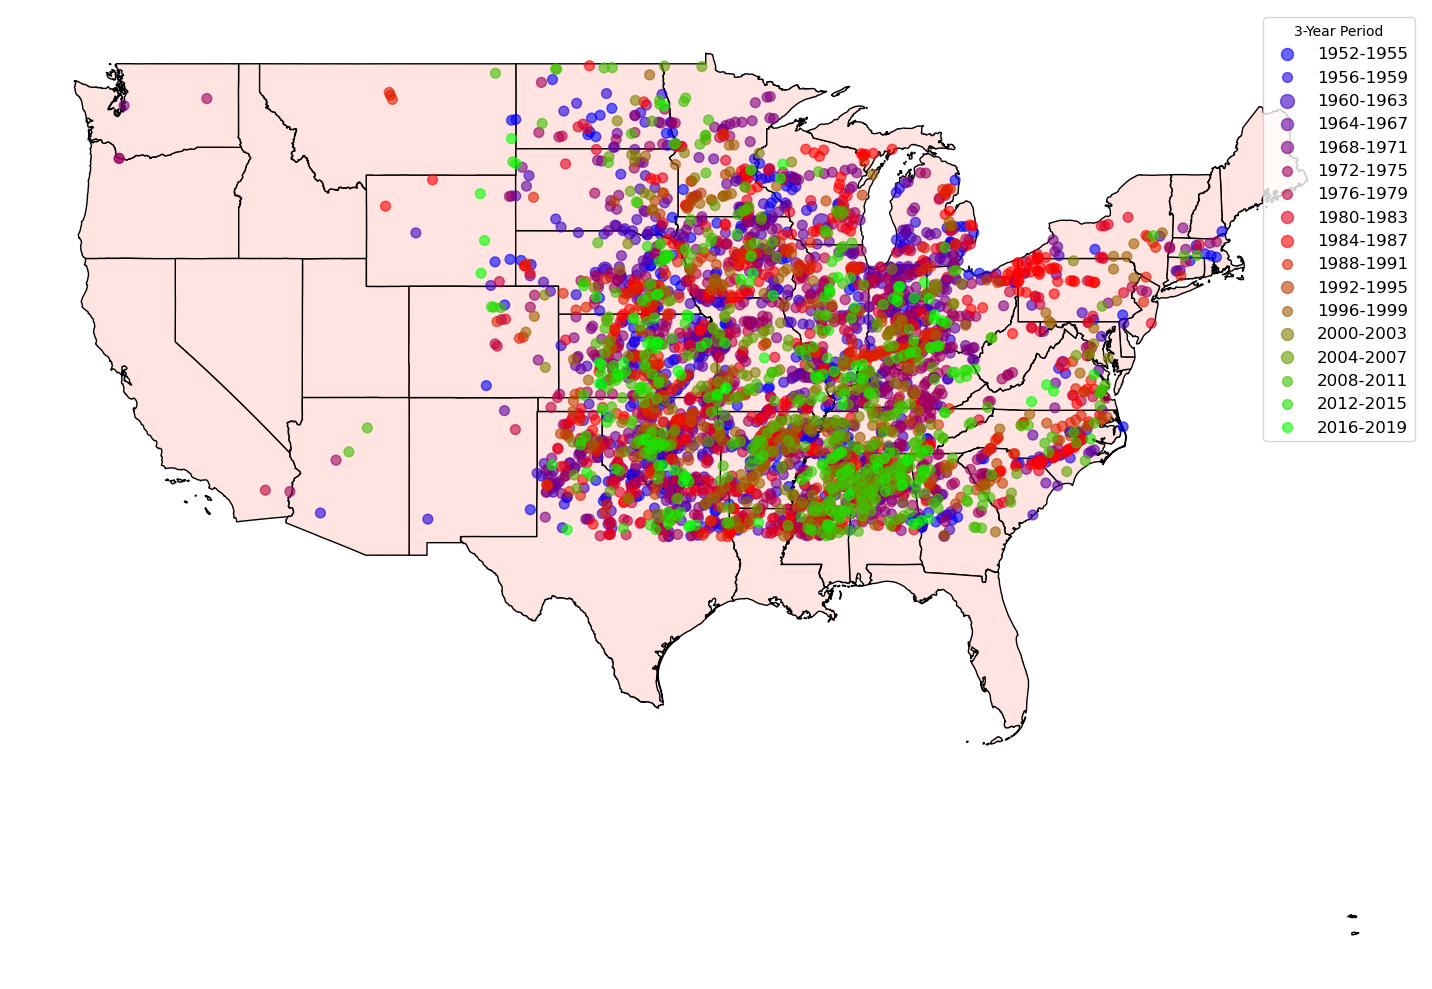

In [23]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


bins = sorted(gdf['year_bin'].unique())


fig, ax = plt.subplots(figsize=(15, 10))


contiguous_states.plot(ax=ax, color='mistyrose', edgecolor='black')


colors = cm.get_cmap('brg', len(bins))  


for i, bin_label in enumerate(bins):
    bin_data = gdf[
        (gdf['year_bin'] == bin_label) & 
        (gdf['tor_f_scale'].isin(['F3', 'F4', 'F5']))
    ]
    if not bin_data.empty:
        bin_data.plot(
            ax=ax,
            color=colors(i),
            markersize=bin_data['count']*50,
            alpha=0.6,
            label=bin_label
        )


ax.set_axis_off()
ax.legend(title='3-Year Period', loc='best', fontsize=12)
plt.tight_layout()
plt.show()



### Now we are going to perform and kernel density estimation for each time frame. Next code will plot and show us the tornado alley is moving

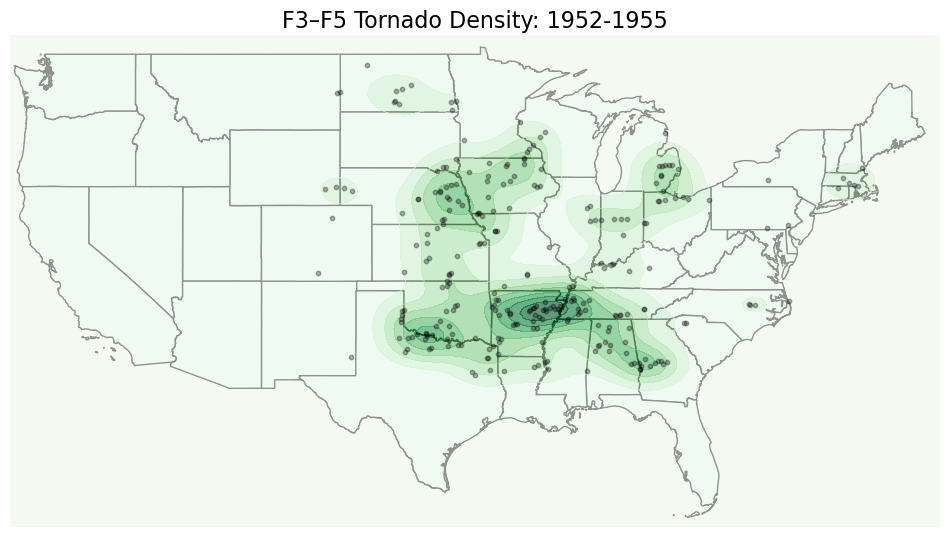

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.animation import FuncAnimation
import geopandas as gpd
from IPython.display import HTML



HTML('<img src="tornadodensity_1950-2020.gif">')

bins = ['1952-1955', '1956-1959', '1960-1963', '1964-1967', '1968-1971',
       '1972-1975', '1976-1979', '1980-1983', '1984-1987', '1988-1991',
       '1992-1995', '1996-1999', '2000-2003', '2004-2007', '2008-2011',
       '2012-2015', '2016-2019']

# Set bounding box for the U.S. map
xmin, xmax = -125, -66
ymin, ymax = 24, 50


xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Remove tornadoes in southeastern coastal zone (likely hurricane-related)
gdf = gdf[(gdf['begin_lon'] >= -81) | (gdf['begin_lat'] >= 32)]



fig, ax = plt.subplots(figsize=(12, 8))

def update(frame):
    ax.clear()
    bin_label = bins[frame]

    
    contiguous_states.plot(ax=ax, color='azure', edgecolor='black')

    bin_data = gdf[
        (gdf['year_bin'] == bin_label) &
        (gdf['tor_f_scale'].isin(['F3', 'F4', 'F5']))
    ]

    x = bin_data['begin_lon'].values
    y = bin_data['begin_lat'].values

    if len(x) > 0:
        xy = np.vstack([x, y])
        kde = gaussian_kde(xy, bw_method=0.2)
        density = kde(positions).reshape(xx.shape)

        contour = ax.contourf(xx, yy, density, levels=10, cmap='Greens', alpha=0.6)
        ax.scatter(x, y, c='black', s=10, alpha=0.3)
        ax.set_title(f"F3–F5 Tornado Density: {bin_label}", fontsize=16)
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_axis_off()
        
    
        
# Animate
anim = FuncAnimation(fig, update, frames=len(bins), interval=1000, repeat=True)

# Show or save
#plt.show()

# Save as GIF (you need 'pillow' installed: `pip install pillow`)
anim.save("1950-2020_tornado_density_plot.gif", writer='pillow', fps=1)
#print("GIF saved as tornado_density_shift.gif")


## Now we will save this data - the mean values of peak latitude and longitude - in a csv file and use it for prediction

In [25]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point


df = pd.read_csv("merged_1952_2019.csv")


high_df = df[df['tor_f_scale'].isin(['F3', 'F4', 'F5'])]


geometry = [Point(xy) for xy in zip(high_df['begin_lon'], high_df['begin_lat'])]
gdf = gpd.GeoDataFrame(high_df, geometry=geometry, crs="EPSG:4326")


us_states = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_5m.zip")

excluded_states = [
    'ALASKA', 'HAWAII', 'PUERTO RICO', 'GUAM', 'AMERICAN SAMOA',
    'COMMONWEALTH OF THE NORTHERN MARIANA ISLANDS', 'UNITED STATES MINOR OUTLYING ISLANDS'
]

us_states['NAME'] = us_states['NAME'].str.upper()
contiguous_states = us_states[~us_states['NAME'].isin(excluded_states)]




import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde


bins = ['1952-1955', '1956-1959', '1960-1963', '1964-1967', '1968-1971',
       '1972-1975', '1976-1979', '1980-1983', '1984-1987', '1988-1991',
       '1992-1995', '1996-1999', '2000-2003', '2004-2007', '2008-2011',
       '2012-2015', '2016-2019']


xmin, xmax = -125, -66
ymin, ymax = 24, 50

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])


density_stats = []

for bin_label in bins:
    bin_data = gdf[
        (gdf['year_bin'] == bin_label) &
        (gdf['tor_f_scale'].isin(['F3', 'F4', 'F5']))
    ]

    x = bin_data['begin_lon'].values
    y = bin_data['begin_lat'].values

    if len(x) > 0:
        xy = np.vstack([x, y])
        kde = gaussian_kde(xy, bw_method=0.5)
        density = kde(positions).reshape(xx.shape)

        max_idx = np.argmax(density)
        peak_lon = xx.ravel()[max_idx]
        peak_lat = yy.ravel()[max_idx]
        peak_density = density.ravel()[max_idx]

        density_stats.append({
            'year_bin': bin_label,
            'peak_lat': peak_lat,
            'peak_lon': peak_lon,
            'peak_density': peak_density,
            'mean_lat': np.mean(y),
            'mean_lon': np.mean(x),
            'std_lat': np.std(y),
            'std_lon': np.std(x),
            'num_points': len(x)
        })
    else:
        # Adding a placeholder for empty bins
        density_stats.append({
            'year_bin': bin_label,
            'peak_lat': np.nan,
            'peak_lon': np.nan,
            'peak_density': 0,
            'mean_lat': np.nan,
            'mean_lon': np.nan,
            'std_lat': np.nan,
            'std_lon': np.nan,
            'num_points': 0
        })

df_stats = pd.DataFrame(density_stats)
df_stats.to_csv("data_tornado-density-peaks.csv", index=False)
